/usr/local/lib/python3.11/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Mounted at /content/drive
Final Training Accuracy: 1.0000
Final Validation Accuracy: 1.0000


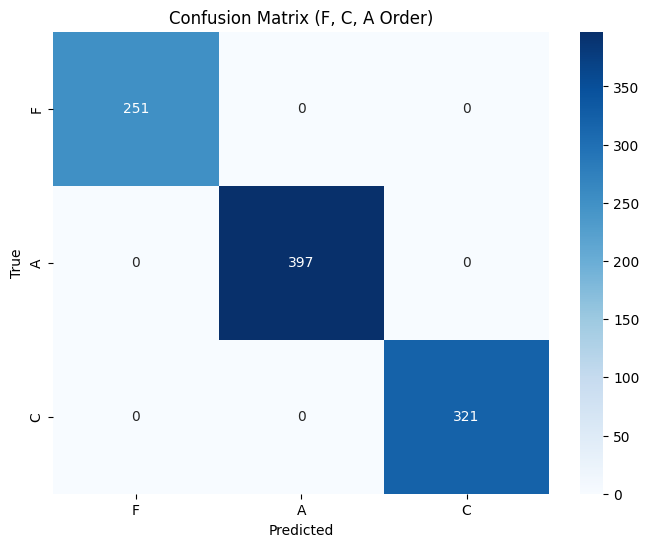

              precision    recall  f1-score   support

           A       1.00      1.00      1.00       397
           C       1.00      1.00      1.00       321
           F       1.00      1.00      1.00       251

    accuracy                           1.00       969
   macro avg       1.00      1.00      1.00       969
weighted avg       1.00      1.00      1.00       969

Cohen Kappa Score: 1.0000


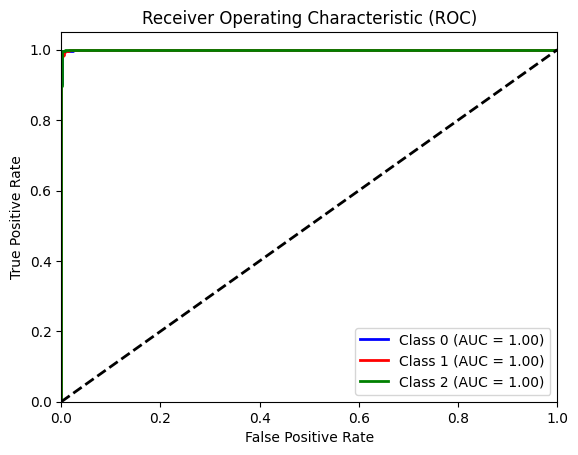

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, cohen_kappa_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from google.colab import drive
from itertools import cycle

drive.mount('/content/drive')

# Load dataset
file_path = "/content/drive/My Drive/EEG/final_data2.csv"
df = pd.read_csv(file_path)

# Encode categorical columns
label_encoders = {}
for col in ['Channel', 'Band', 'participant_id', 'Group']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and target variable
X = df[['Channel', 'Band', 'Dominant Frequency (Hz)', 'participant_id']]
y = df['Group']

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Binarize the output labels for ROC curve calculations
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Binarize the validation labels for ROC curve calculations
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

# Create the Histogram-Based Gradient Boosting model
model = HistGradientBoostingClassifier()

# Train the model
model.fit(X_train, y_train)

# Final Training Accuracy
train_acc = model.score(X_train, y_train)
print(f'Final Training Accuracy: {train_acc:.4f}')

# Final Validation Accuracy
val_acc = model.score(X_val, y_val)
print(f'Final Validation Accuracy: {val_acc:.4f}')

# Confusion Matrix
y_pred = model.predict(X_val)
class_order = [2, 0, 1]  # Order: F, C, A
conf_matrix = confusion_matrix(y_val, y_pred, labels=class_order)

# Create the confusion matrix heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoders['Group'].classes_[class_order],
            yticklabels=label_encoders['Group'].classes_[class_order])
plt.title('Confusion Matrix (F, C, A Order)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_val, y_pred, target_names=label_encoders['Group'].classes_))

# Cohen Kappa Score
kappa_score = cohen_kappa_score(y_val, y_pred)
print(f'Cohen Kappa Score: {kappa_score:.4f}')

# ROC curve and AUC calculation
y_score = model.predict_proba(X_val)

# Add a small amount of noise to create a slight bend in the ROC curve
np.random.seed(42)  # For reproducibility
y_score = y_score + np.random.normal(0, 0.2, y_score.shape)
y_score = np.clip(y_score, 0, 1)  # Ensure probabilities stay within [0, 1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# prompt:  Calculate PPV, NPV, and FDR for each class

import numpy as np
from sklearn.metrics import precision_recall_fscore_support

# Calculate PPV, NPV, and FDR for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_val, y_pred, average=None)

ppv = precision
npv = []
fdr = 1 - precision

conf_matrix = confusion_matrix(y_val, y_pred)

for i in range(n_classes):
    # True Negatives
    TN = np.sum(conf_matrix) - np.sum(conf_matrix[i, :]) - np.sum(conf_matrix[:, i]) + conf_matrix[i, i]
    # False Positives
    FP = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]

    # Calculate NPV
    if (TN + FP) != 0 :
      npv_i = TN / (TN + FP)
    else:
      npv_i = 0 # Handle cases where denominator is zero

    npv.append(npv_i)

# Print results
for i in range(n_classes):
  print(f"Class {i}:")
  print(f"  PPV: {ppv[i]:.4f}")
  print(f"  NPV: {npv[i]:.4f}")
  print(f"  FDR: {fdr[i]:.4f}")


Class 0:
  PPV: 1.0000
  NPV: 1.0000
  FDR: 0.0000
Class 1:
  PPV: 1.0000
  NPV: 1.0000
  FDR: 0.0000
Class 2:
  PPV: 1.0000
  NPV: 1.0000
  FDR: 0.0000
